#  https://github.com/byschii/ecg-segmentation/tree/main
### Functions for reading the data and preprocessing from this repository.
### Comparing LSTM results to UNET

In [1]:
import os
import numpy as np
import wfdb
import torch
from tqdm import tqdm
from customLib.lobachevsky import EGCSignal, get_class_weights
from customLib.dataset import split_dataset
from models.datasets import ECGDataset

In [2]:
LEADS = ['avf', 'avl', 'avr', 'i', 'ii', 'iii', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6']

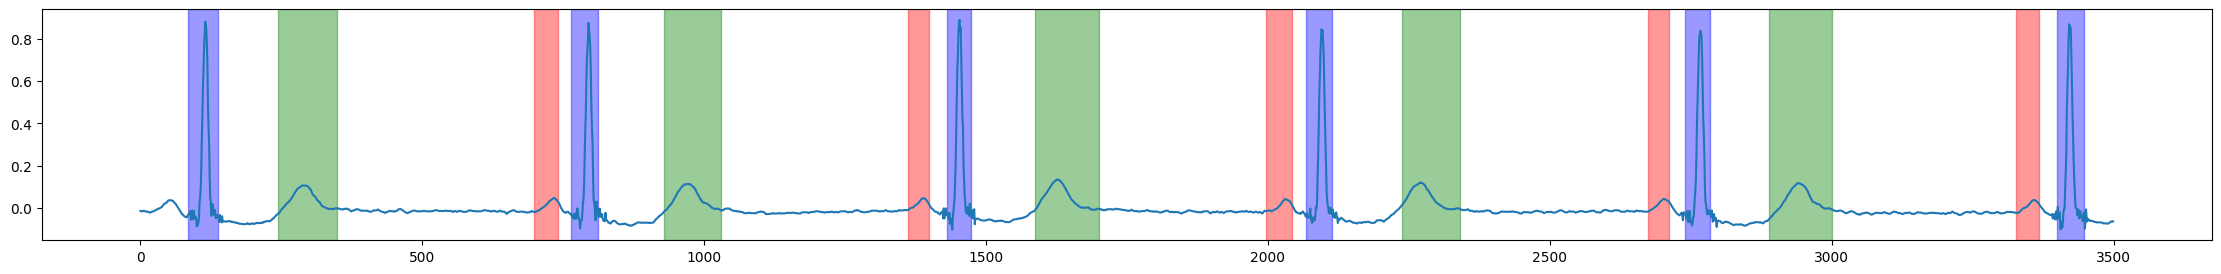

In [3]:
EGCSignal.from_index_and_lead(1, LEADS[0]).plot_with_segments()

### Data preprocessing
Change to the original notebook - from to_categorical to one_hot by hand because I am using just torch

Pytorch docs - CrossEntropyLoss criterion is generally better when `target` contains class indices, as this follows for optimized computation. Therefore I will not use one-hot encoding here. 

In [81]:
def one_hot(categories, num_classes):
    return np.eye(num_classes)[categories]

In [4]:
import random
import copy
from torch import nn

ECG_SIZE=512
X = []
Y = []
for ecg_index in range(1,200):
    print(ecg_index, end = ', ')
    for lead in LEADS:
        try:
            start = 0
            s = EGCSignal.from_index_and_lead(ecg_index, lead)
            for ecg_part in range(0, 4):
                s_copy = copy.deepcopy(s)

                span = ECG_SIZE
                start += random.randint(0, 50) + span
                s_copy._cut_beginning(start)
                s_copy._cut_end(span)

                # append the signal to X, also adding a new dimension
                X.append(s_copy.signal)
                # append the category to Y
                Y.append((s_copy.categories + 1).astype(int))
        except:
            pass

X = np.array(X)
X = np.expand_dims(X, axis=2)
Y = np.array(Y)

1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 

In [6]:
x_train, y_train, x_test, y_test, x_val, y_val = split_dataset(X, Y, is_validation_set=True, shuffle=True)

Total ECGs: 9432


c:\Users\patry\OneDrive\Elearning - PG\WETI\masters-thesis\customLib\dataset.py:34: UserWarning: Path is not specified. The dataset is not being saved.
  warnings.warn("Path is not specified. The dataset is not being saved.")


### Model - I am going to use a LSTM network

In [7]:
from torch import nn

class SegRNN(nn.Module):
    def __init__(self, input_dim, hidden_size, num_lstm_layers=2, out_size=4, dropout=0.5):
        super(SegRNN, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_size, batch_first=True, bidirectional=True, num_layers=num_lstm_layers)
        self.fc = nn.Sequential(
            nn.Linear(2*hidden_size, 2*hidden_size),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(2*hidden_size, 2*hidden_size),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout)
        )
        self.output = nn.Linear(2*hidden_size, out_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out)
        return self.output(out)

In [24]:
class_weights = get_class_weights(y_train[:10], normalize=False)
print("Class weights : ", class_weights)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SegRNN(input_dim=1, hidden_size=256, num_lstm_layers=1)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = torch.nn.CrossEntropyLoss(weight=torch.Tensor(class_weights).to(dtype=torch.float32, device=device))

train_dataset = ECGDataset(x_train, y_train)
validation_dataset = ECGDataset(x_val, y_val)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=20)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=20)


Class weights :  [ 1.61056936  9.02998236  5.73991031 10.62240664]


In [25]:
from torchmetrics.classification import JaccardIndex #, MulticlassJaccardIndex
from torchmetrics.classification import BinaryF1Score, ConfusionMatrix

def calculate_metrics(y: np.array, pred: np.array, verbose=False, seq_length=512):
    WAVE_TO_COLUMN = {
        "None": 0,
        "P": 1,
        "QRS": 2,
        "T": 3,
    }

    WAVE_METRICS = {
        "None": {},
        "P": {},
        "QRS": {},
        "T": {},
    }

    for wave_name, column_index in WAVE_TO_COLUMN.items():
        metrics = {
            "F1_score": 0,
            "confusion_matrix": ConfusionMatrix(task="binary", num_classes=2),
            "TPR": 0,
            "FPR": 0,
            "TNR": 0,
            "FNR": 0,
            "mean_iou": JaccardIndex(task="binary")
        }

        wave_test = (y == column_index).astype(int)
        wave_pred = (np.argmax(pred, axis=1) == column_index).astype(int)

        wave_test = torch.tensor(wave_test)
        wave_pred = torch.tensor(wave_pred)

        metrics["F1_score"] = BinaryF1Score()(wave_pred, wave_test).item()
        metrics["mean_iou"].update(wave_pred, wave_test)
        metrics["mean_iou"] = metrics["mean_iou"].compute().item()

        metrics["confusion_matrix"].update(wave_pred, wave_test)
        final_conf_matrix = metrics["confusion_matrix"].compute()

        tp = final_conf_matrix[1, 1].item()
        tn = final_conf_matrix[0, 0].item()
        fp = final_conf_matrix[0, 1].item()
        fn = final_conf_matrix[1, 0].item()

        metrics["TPR"] = tp / (tp + fn) if (tp + fn) > 0 else 0
        metrics["FPR"] = fp / (fp + tn) if (fp + tn) > 0 else 0
        metrics["TNR"] = tn / (tn + fp) if (tn + fp) > 0 else 0
        metrics["FNR"] = fn / (fn + tp) if (fn + tp) > 0 else 0

        WAVE_METRICS[wave_name] = metrics
    
    if verbose:
        print("\n" + "="*50)
        print(f"{'Wave Type':<10} {'F1 Score':<10} {'Mean IoU':<10} {'TPR':<8} {'FPR':<8} {'TNR':<8} {'FNR':<8}")
        print("-"*50)
        for wave_name, metrics in WAVE_METRICS.items():
            print(f"{wave_name:<10} "
                  f"{metrics['F1_score']:<10.4f} "
                  f"{metrics['mean_iou']:<10.4f} "
                  f"{metrics['TPR']:<8.4f} "
                  f"{metrics['FPR']:<8.4f} "
                  f"{metrics['TNR']:<8.4f} "
                  f"{metrics['FNR']:<8.4f}")
        print("="*50 + "\n")
    
    return WAVE_METRICS



In [26]:
def validate(model):
    model.eval()
    running_vloss = 0.0
    total = 0
    correct = 0
    for i, (inputs, labels) in tqdm(enumerate(validation_loader), total=len(validation_loader)):
        inputs = inputs.to(device)
        labels = labels.type(dtype=torch.LongTensor)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        outputs = outputs.view(-1, outputs.shape[-1])
        labels = labels.view(-1)

        loss = criterion(outputs, labels)
        running_vloss += loss.item()

        total += labels.shape[0]
        correct += torch.sum(torch.argmax(outputs, dim=1) == labels).item()

    print(f"Validation loss: {round(running_vloss/len(validation_loader), 6)}")
    print(f"Accuracy: {round(correct / total * 100, 4)}%\n")

def train(model, epochs):
    for epoch in range(epochs):
        total = correct = running_loss = 0 
        model.train()

        all_outputs = []
        all_labels = []

        print(f"==========Epoch [{epoch+1}/{epochs}]===========\n")
        for i, (inputs, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
            inputs = inputs.to(device)
            labels = labels.type(dtype=torch.LongTensor)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)

            outputs = outputs.view(-1, outputs.shape[-1])
            labels = labels.view(-1)
            
            loss = criterion(outputs, labels)

            loss.backward()
            running_loss += loss.item()

            total += labels.shape[0]
            correct += torch.sum(torch.argmax(outputs, dim=1) == labels).item()

            optimizer.step()

            all_outputs.extend(outputs.cpu().detach().numpy())
            all_labels.extend(labels.cpu().detach().numpy())
        
        all_outputs = np.array(all_outputs) #(169984, 4)
        all_labels = np.array(all_labels) # (169984,)

        print(f"Train loss: {round(running_loss/len(train_loader), 6)}")
        print(f"Accuracy: {round(correct / total * 100, 4)}%\n")
        calculate_metrics(all_labels, all_outputs, verbose=True, seq_length=inputs.shape[1])

        if validation_loader is not None:
            validate(model)

In [27]:
train(model, 25)

==========Epoch [1/25]===========



100%|██████████| 378/378 [00:48<00:00,  7.74it/s]


Train loss: 1.195116
Accuracy: 33.2726%


Wave Type  F1 Score   Mean IoU   TPR      FPR      TNR      FNR     
--------------------------------------------------
None       0.3302     0.1978     0.2125   0.1091   0.8909   0.7875  
P          0.4732     0.3099     0.4874   0.0710   0.9290   0.5126  
QRS        0.3753     0.2310     0.6106   0.4131   0.5869   0.3894  
T          0.1697     0.0927     0.3170   0.2538   0.7462   0.6830  



100%|██████████| 48/48 [00:02<00:00, 16.59it/s]


Validation loss: 0.968079
Accuracy: 63.6174%

==========Epoch [2/25]===========



100%|██████████| 378/378 [00:48<00:00,  7.79it/s]


Train loss: 0.906755
Accuracy: 59.8668%


Wave Type  F1 Score   Mean IoU   TPR      FPR      TNR      FNR     
--------------------------------------------------
None       0.6976     0.5356     0.6035   0.1852   0.8148   0.3965  
P          0.8110     0.6820     0.8642   0.0331   0.9669   0.1358  
QRS        0.4918     0.3261     0.5437   0.1677   0.8323   0.4563  
T          0.2437     0.1387     0.3765   0.1797   0.8203   0.6235  



100%|██████████| 48/48 [00:02<00:00, 16.54it/s]


Validation loss: 0.856172
Accuracy: 67.9944%

==========Epoch [3/25]===========



100%|██████████| 378/378 [00:48<00:00,  7.79it/s]


Train loss: 0.833127
Accuracy: 66.7575%


Wave Type  F1 Score   Mean IoU   TPR      FPR      TNR      FNR     
--------------------------------------------------
None       0.7635     0.6175     0.6887   0.1687   0.8313   0.3113  
P          0.8166     0.6900     0.8932   0.0365   0.9635   0.1068  
QRS        0.5458     0.3753     0.5862   0.1412   0.8588   0.4138  
T          0.3307     0.1981     0.4456   0.1310   0.8690   0.5544  



100%|██████████| 48/48 [00:02<00:00, 16.69it/s]


Validation loss: 0.79532
Accuracy: 68.937%

==========Epoch [4/25]===========



100%|██████████| 378/378 [00:50<00:00,  7.42it/s]


Train loss: 0.747018
Accuracy: 69.0735%


Wave Type  F1 Score   Mean IoU   TPR      FPR      TNR      FNR     
--------------------------------------------------
None       0.7648     0.6192     0.6783   0.1395   0.8605   0.3217  
P          0.7890     0.6515     0.8959   0.0465   0.9535   0.1041  
QRS        0.6050     0.4337     0.6612   0.1319   0.8681   0.3388  
T          0.4378     0.2803     0.5928   0.1169   0.8831   0.4072  



100%|██████████| 48/48 [00:03<00:00, 15.82it/s]


Validation loss: 0.684553
Accuracy: 72.9475%

==========Epoch [5/25]===========



100%|██████████| 378/378 [00:49<00:00,  7.61it/s]


Train loss: 0.655981
Accuracy: 70.5914%


Wave Type  F1 Score   Mean IoU   TPR      FPR      TNR      FNR     
--------------------------------------------------
None       0.7580     0.6103     0.6616   0.1228   0.8772   0.3384  
P          0.7908     0.6540     0.8880   0.0443   0.9557   0.1120  
QRS        0.6473     0.4786     0.7365   0.1355   0.8645   0.2635  
T          0.5192     0.3506     0.7071   0.1066   0.8934   0.2929  



100%|██████████| 48/48 [00:03<00:00, 15.94it/s]


Validation loss: 0.600187
Accuracy: 73.6365%

==========Epoch [6/25]===========



100%|██████████| 378/378 [00:48<00:00,  7.76it/s]


Train loss: 0.583847
Accuracy: 71.5928%


Wave Type  F1 Score   Mean IoU   TPR      FPR      TNR      FNR     
--------------------------------------------------
None       0.7519     0.6025     0.6480   0.1104   0.8896   0.3520  
P          0.8041     0.6724     0.9021   0.0423   0.9577   0.0979  
QRS        0.6780     0.5129     0.7977   0.1396   0.8604   0.2023  
T          0.5569     0.3859     0.7518   0.0995   0.9005   0.2482  



100%|██████████| 48/48 [00:02<00:00, 17.05it/s]


Validation loss: 0.563426
Accuracy: 75.437%

==========Epoch [7/25]===========



100%|██████████| 378/378 [00:48<00:00,  7.77it/s]


Train loss: 0.545146
Accuracy: 72.6452%


Wave Type  F1 Score   Mean IoU   TPR      FPR      TNR      FNR     
--------------------------------------------------
None       0.7593     0.6120     0.6548   0.1023   0.8977   0.3452  
P          0.8169     0.6905     0.9125   0.0398   0.9602   0.0875  
QRS        0.6931     0.5304     0.8135   0.1342   0.8658   0.1865  
T          0.5703     0.3989     0.7743   0.0987   0.9013   0.2257  



100%|██████████| 48/48 [00:02<00:00, 17.05it/s]


Validation loss: 0.538588
Accuracy: 76.2636%

==========Epoch [8/25]===========



100%|██████████| 378/378 [00:48<00:00,  7.77it/s]


Train loss: 0.519734
Accuracy: 73.7688%


Wave Type  F1 Score   Mean IoU   TPR      FPR      TNR      FNR     
--------------------------------------------------
None       0.7695     0.6253     0.6675   0.0986   0.9014   0.3325  
P          0.8255     0.7028     0.9213   0.0385   0.9615   0.0787  
QRS        0.7038     0.5429     0.8227   0.1295   0.8705   0.1773  
T          0.5861     0.4146     0.7836   0.0933   0.9067   0.2164  



100%|██████████| 48/48 [00:02<00:00, 16.51it/s]


Validation loss: 0.509185
Accuracy: 76.2628%

==========Epoch [9/25]===========



 36%|███▌      | 136/378 [00:17<00:31,  7.71it/s]


KeyboardInterrupt: 

In [ ]:
# https://github.com/byschii/ecg-segmentation/tree/main 

def find_wave_onset(wave_category:list) -> np.ndarray:
    """
    Check where the wave starts
    """
    onsets = []
    prev = None
    for i, val in enumerate(wave_category):
        if val != 0 and prev == 0:
            onsets.append(i)
        prev = val
    return np.array(onsets)

def find_wave_offset(wave_category:list) -> np.ndarray:
    """
    Check where the wave ends
    """
    offsets = []
    prev = None
    for i, val in enumerate(wave_category):
        if val == 0 and prev != 0:
            offsets.append(i)
        prev = val
    return np.array(offsets)

def get_probably_matching_timepoints(shorter:np.ndarray, longer:np.ndarray):
    indices_minimizind_distancies = [
        np.argmin(row) for row in np.abs(np.subtract.outer(shorter, longer))
    ]
    return longer[indices_minimizind_distancies]


def get_true_false_errs_from_mismatching_timepoints(shorter:np.ndarray, longer:np.ndarray, toll:int):
    if len(shorter) == 0:
        return len(longer), 0, []

    falses = len(longer) - len(shorter)

    matched_longer = get_probably_matching_timepoints(shorter, longer)

    dists = np.abs(matched_longer - shorter)

    trues = np.sum(dists <= toll)
    errs = list(dists[dists < toll])

    return falses, trues, errs 


WAVE_TO_COLUMN = {
    "None": 0,
    "P":3,
    "QRS":1,
    "T":2,
}

WAVE_DATA = {
    "None": None,
    "P": {},
    "QRS": {},
    "T": {},
}

EXTRA_WAVE_DATA = {
    "None": {},
    "P": {},
    "QRS": {},
    "T": {},
}

In [59]:
x_test_tensor = torch.from_numpy(x_test)
x_test_tensor = x_test_tensor.float().to(device)

prediction = model(x_test_tensor)
prediction = prediction.cpu().detach().numpy()

prediction_indices = np.argmax(np.resize(prediction, (prediction.shape[0] * prediction.shape[1], prediction.shape[2])), axis=1) # flatten the batch and seq_length dimensions, and get the max value indice
total = x_test.shape[0] * x_test.shape[1] # batch_size * seq_length
test_acc = np.where(prediction_indices == y_test.flatten())[0].shape[0] / total * 100 # all where prediction matches the ground_truth divided by all samples count
print(f"Test accuracy: {test_acc:.4f}%")

Test accuracy: 81.4043%


In [187]:
toll = 75

F1 = BinaryF1Score()
conf_matrics = ConfusionMatrix(task="binary", num_classes=2)

for wave_name, column_index in WAVE_TO_COLUMN.items():
    if column_index == 0:
        continue
    print("Checking", wave_name)
    for phase, time_point_function in zip(["onset", "offset"],[find_wave_onset, find_wave_offset]):

        evaluation = {
            "TP": 0,
            "FP": 0,
            "FN": 0,
            "errors": [],
            "mean_iou": JaccardIndex(task="binary"),
            "confusion_matrix": torch.tensor([[0,0],[0,0]]),
            "F1_score": 0,
            "TPR": 0,
            "FPR": 0,
            "TNR": 0,
            "FNR": 0,
            "mean_iou": JaccardIndex(task="binary")
        }


        for gt, y_pred in zip(y_test, prediction):
            wave_test = (gt == column_index).astype(int)                        # we kinda switch to binary classification problem -> we check for one wave type at a time
            wave_pred = (np.argmax(y_pred, axis=1) == column_index).astype(int) # both of shape (num_timesteps, )

            wave_test_points = time_point_function(wave_test)
            wave_pred_points = time_point_function(wave_pred)

            try:
                if len(wave_test_points) == len(wave_pred_points):
                    # i ASSUME that wave match and that there might be true positives
                    # still have to if correspoding points are in the tollerance
                    _, trues, errs = get_true_false_errs_from_mismatching_timepoints(wave_test_points, wave_pred_points, toll)
                    evaluation["TP"] += trues
                    evaluation["errors"] += errs
                    
                elif len(wave_test_points) > len(wave_pred_points):
                    # if 'wave_test_points' is longer i have false negatives
                    falses, trues, errs = get_true_false_errs_from_mismatching_timepoints(wave_pred_points, wave_test_points, toll)
                    evaluation["TP"] += trues
                    evaluation["FN"] += falses
                    evaluation["errors"] += errs

                elif len(wave_test_points) < len(wave_pred_points):
                    # if 'wave_pred_points' is longer i have false positives
                    falses, trues, errs = get_true_false_errs_from_mismatching_timepoints(wave_test_points, wave_pred_points, toll)

                    evaluation["TP"] += trues
                    evaluation["FP"] += falses
                    evaluation["errors"] += errs
            except Exception as e:
                print(wave_test_points, wave_pred_points, len(wave_test_points), len(wave_pred_points))
                raise e

            wave_test = torch.from_numpy(wave_test)
            wave_pred = torch.from_numpy(wave_pred)
            evaluation["mean_iou"].update(wave_pred, wave_test)
            evaluation["confusion_matrix"] += conf_matrics(wave_pred, wave_test)

        evaluation["F1_score"] /= y_test.shape[0] # average over all examples
        tp = evaluation["confusion_matrix"][0][0].item()
        tn = evaluation["confusion_matrix"][1][1].item()
        fp = evaluation["confusion_matrix"][0][1].item()
        fn = evaluation["confusion_matrix"][1][0].item()

        evaluation["TPR"] = tp / (tp + fn) if (tp + fn) > 0 else 0
        evaluation["FPR"] = fp / (fp + tn) if (fp + tn) > 0 else 0
        evaluation["TNR"] = tn / (tn + fp) if (tn + fp) > 0 else 0
        evaluation["FNR"] = fn / (fn + tp) if (fn + tp) > 0 else 0

        WAVE_DATA[wave_name][phase] = evaluation


Checking P
Checking QRS
Checking T


In [42]:
for wave_name, _ in WAVE_DATA.items():
    if wave_name == "None":
        continue
    print(f"{wave_name} mean_iou onset: ", WAVE_DATA[wave_name]["onset"]["mean_iou"].compute())
    print(f"{wave_name} mean_iou offset: ", WAVE_DATA[wave_name]["offset"]["mean_iou"].compute(), "\n")

for wave_name, _ in WAVE_DATA.items():
    if wave_name == "None":
        continue
    print(f"{wave_name} Average F1_score onset: ", WAVE_DATA[wave_name]["onset"]["F1_score"].item())
    print(f"{wave_name} Average F1_score offset: ", WAVE_DATA[wave_name]["offset"]["F1_score"].item(), "\n")

for wave_name, _ in WAVE_DATA.items():
    if wave_name == "None":
        continue
    print(f"{wave_name} Average F1_score onset: ", WAVE_DATA[wave_name]["onset"]["F1_score"])
    print(f"{wave_name} Average F1_score offset: ", WAVE_DATA[wave_name]["offset"]["F1_score"], "\n")

P mean_iou onset:  tensor(0.5563)
P mean_iou offset:  tensor(0.5563) 

QRS mean_iou onset:  tensor(0.7979)
QRS mean_iou offset:  tensor(0.7979) 

T mean_iou onset:  tensor(0.5596)
T mean_iou offset:  tensor(0.5596) 

P F1_score onset:  tensor(0.6779)
P F1_score offset:  tensor(0.6779) 

QRS F1_score onset:  tensor(0.8805)
QRS F1_score offset:  tensor(0.8805) 

T F1_score onset:  tensor(0.7005)
T F1_score offset:  tensor(0.7005) 



In [37]:
metric = MulticlassJaccardIndex(num_classes=4, average=None)

for gt, y_pred in zip(y_test, prediction):
    y_pred_indices = np.argmax(y_pred, axis=1)
    metric.update(torch.from_numpy(gt), torch.from_numpy(y_pred_indices))

metric.compute()


tensor([0.7408, 0.7979, 0.5596, 0.5563])